# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

###### I was facing issues handling azdias dataset (timeout/ workspace is idle etc.). I decided to use sample azdias instead of  the complete dataset 

In [2]:
f = '../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv'
num_lines = sum(1 for l in open(f))

size = int(num_lines/2.5)
skip_idx = random.sample(range(1,num_lines),num_lines - size)
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',skiprows=skip_idx)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


One thing to notice after loading both azdias and customers dataset is columns 18 and 19 are of mixed types. Let's see which columns are column 18 and 19

In [4]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [5]:
azdias.CAMEO_DEUG_2015.value_counts()

8      29956
8.0    23903
9      23893
6      23239
4      22983
9.0    19253
3      19146
6.0    19090
4.0    18660
2      18180
7      17251
3.0    15459
2.0    15227
7.0    13832
5      12310
5.0     9744
1       7960
1.0     6489
X        145
Name: CAMEO_DEUG_2015, dtype: int64

In [6]:
azdias.CAMEO_INTL_2015.value_counts(0)

51      29500
51.0    23811
41      20649
24      20154
24.0    16334
41.0    16325
14      13804
43      12466
14.0    11517
43.0    10301
54      10020
25       8674
54.0     8125
22       7349
25.0     7084
23       5952
22.0     5906
13       5798
45       5628
55       5357
23.0     4795
13.0     4774
52       4603
45.0     4599
55.0     4262
31       4216
34       4150
15       3690
52.0     3636
31.0     3376
34.0     3244
44       3232
15.0     3040
12       2848
44.0     2698
35       2419
12.0     2385
32       2266
33       2143
35.0     1849
32.0     1826
33.0     1770
XX        145
Name: CAMEO_INTL_2015, dtype: int64

We need to replace X in CAMEO_DEUG_2015 and rows with value XX in CAMEO_INTL_2015 from both azdias and customers dataset. Also, notice in CAMEO_DEUG_2015 and CAMEO_DEUG_2015, 1 and 1.0 is same, as they represent the same class.  

In [7]:
def mixed_feature_handler(df):
    '''
    This function deals with the special characters in the cameo columns
    Finds the special characters and replaces them with nan
    '''
    
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    df[cols] = df[cols].replace({'X': np.nan, 'XX':np.nan, '': np.nan, ' ':np.nan})
    df[cols] = df[cols].astype(float)
       
    return df

In [8]:
azdias = mixed_feature_handler(azdias)
customer = mixed_feature_handler(customers)

azdias.CAMEO_INTL_2015.value_counts()

51.0    53311
41.0    36974
24.0    36488
14.0    25321
43.0    22767
54.0    18145
25.0    15758
22.0    13255
23.0    10747
13.0    10572
45.0    10227
55.0     9619
52.0     8239
31.0     7592
34.0     7394
15.0     6730
44.0     5930
12.0     5233
35.0     4268
32.0     4092
33.0     3913
Name: CAMEO_INTL_2015, dtype: int64

##### Getting some basic stats related to azdias dataset - like shape, mean, standard deviation, different percentiles

In [9]:
azdias.shape

(356487, 366)

In [10]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
1,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
2,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
3,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
4,645169,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2


In [11]:
pd.set_option('display.max_rows', 500)
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,356487.0,637332.359853,257345.629829,191655.0,414305.5,637730.0,860075.5,1082868.0
AGER_TYP,356487.0,-0.357965,1.199163,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,327036.0,4.419981,3.637819,1.0,1.0,3.0,9.0,9.0
ALTER_HH,327036.0,10.879432,7.633433,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,32137.0,11.780222,4.095689,2.0,8.0,12.0,15.0,18.0
ALTER_KIND2,11693.0,13.402206,3.232858,2.0,11.0,14.0,16.0,18.0
ALTER_KIND3,2476.0,14.516559,2.664417,5.0,13.0,15.0,17.0,18.0
ALTER_KIND4,464.0,15.109914,2.406522,8.0,14.0,15.0,17.0,18.0
ALTERSKATEGORIE_FEIN,251299.0,13.716815,5.059027,0.0,11.0,14.0,17.0,25.0
ANZ_HAUSHALTE_AKTIV,319031.0,8.267118,15.481250,0.0,1.0,4.0,10.0,595.0


##### Getting some basic stats related to customers dataset - like shape, mean, standard deviation, different percentiles

In [12]:
customers.shape

(191652, 369)

In [13]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Next, I am reading description of these columns to get an idea what these attributes really means.

In [14]:
dias_information = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx')
dias_information.drop('Unnamed: 0', axis=1, inplace=True)
dias_information.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [15]:
dias_attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')
dias_attributes.drop('Unnamed: 0', axis=1, inplace=True)
dias_attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


It's not feasible to print out the whole attributes file, as it has ~2.3k rows. I will download the DIAS Attributes - Values 2017.xlsx file to see what different values means in different categories.

#### Convert missing value codes to NaN

I want to identify all the values which are unknown or contiain no in the meaning string. First, I will filter the dias_attribute data frame and using which the same data frame I will replace the missing value code with NaNs. 

In [16]:
dias_attributes['Attribute'] = dias_attributes['Attribute'].fillna(method='ffill')
dias_attributes = dias_attributes[(dias_attributes['Meaning'].str.contains("unknown") | dias_attributes['Meaning'].str.contains("no "))]
dias_attributes[290:]

,Attribute,Description,Value,Meaning
2194,SEMIO_VERT,affinity indicating in what way the person is ...,"-1, 9",unknown
2202,SHOPPER_TYP,shopping typology,-1,unknown
2207,SOHO_FLAG,small office/home office flag,-1,unknown
2208,SOHO_FLAG,NaN,0,no small office/home office
2210,TITEL_KZ,flag whether this person holds an academic title,"-1, 0",unknown
2216,VERS_TYP,insurance typology,-1,unknown
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2230,WOHNLAGE,NaN,0,no score calculated
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown


In [17]:
unknowns = []
features = []

for feature in dias_attributes['Attribute'].unique():
    missing_or_unknown = dias_attributes.loc[dias_attributes['Attribute'] == feature, 'Value'].astype(str).str.cat(sep=',').split(',')
    unknowns.append(missing_or_unknown)
    features.append(feature)
    
unknowns_df = pd.concat([pd.Series(features), pd.Series(unknowns)], axis=1)
unknowns_df.columns = ['attribute', 'missing_or_unknown']
unknowns_df.head()

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


### Replacing Nan's code with Nan values

In [18]:
def replacing_with_nan(df):
    for row in unknowns_df['attribute']:
        if row in azdias.columns:
            na_map = unknowns_df.loc[unknowns_df['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df.loc[:, row].isin(na_map)
            df.loc[na_idx, row] = np.NaN
        else:
            continue
            
    return df

Replacing unknown code values with NaN for both customers and azdias dataset.

In [19]:
customers = replacing_with_nan(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0


In [20]:
azdias = replacing_with_nan(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
2,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
3,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4.0,2.0,2.0
4,645169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0


As of now, I am preprocessing only azdias dataset. Later, I will create I will create a function to perform similar preprcessing on the customer dataset as well. 

### Deleting columns with null values

##### Handing Null Values and checking their distributions

First, let's see what is the distribution of null values accross the columns. I am going to create a dataframe to store the percentage of null values in columns.

In [21]:
def identify_columns_null_values(df):
    
    '''
    This function takes a dataframe as an input and resturn a list of all the columns where
    null values are more than 40% of the total values in the column
    '''

    df_null = df.isnull().sum()
    df_null_percent = df_null / len(df) * 100

    df_null_percent.sort_values()[330:].plot.barh(figsize=(10,10),fontsize=12,color='teal')
    print('columns having  missing values >40% : ',len(df_null_percent[df_null_percent>40].index))
    
    df_null_list = list(df_null_percent[df_null_percent>40].index)
    return df_null_list

columns having  missing values >40% :  37


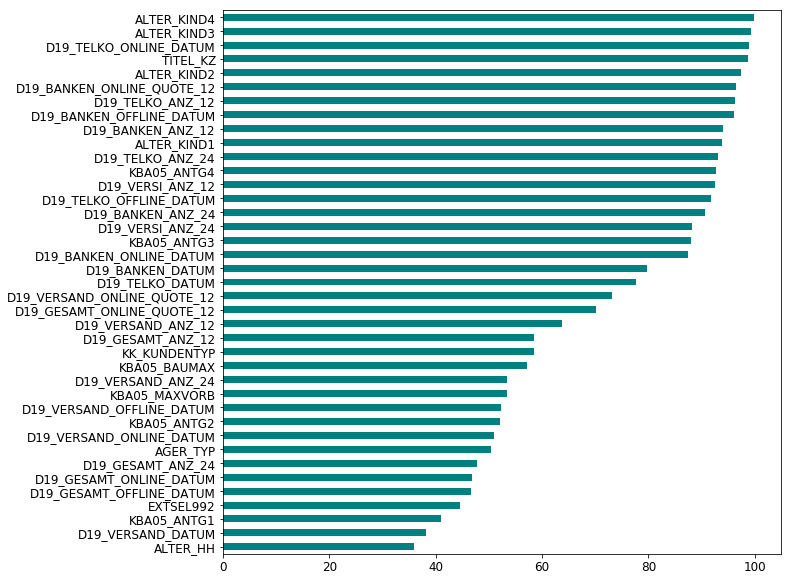

In [22]:
customers_null_list = identify_columns_null_values(customers)

columns having  missing values >40% :  37


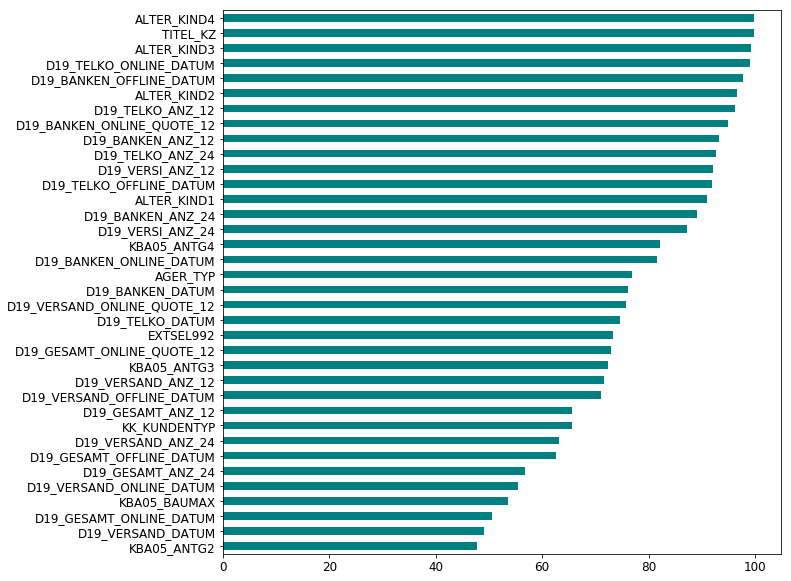

In [23]:
azdias_null_list = identify_columns_null_values(azdias)

In [24]:
len(list(set(customers_null_list) & set(azdias_null_list)))

36

There are 36 columns where 40% of the values are null are common in both azdias and customers dataset. 

In [25]:
len(list(set(customers_null_list) | set(azdias_null_list)))

38

However, to remain consistent we need to remove all 38 columns from both the dataset.

In [26]:
columns_to_drop = list(set(customers_null_list) | set(azdias_null_list))

In [27]:
azdias.drop(columns_to_drop, axis=1, inplace = True)
customers.drop(columns_to_drop, axis=1, inplace = True)

In [28]:
print(azdias.shape)
print(customers.shape)

(356487, 328)
(191652, 331)


### Removing rows with missing values

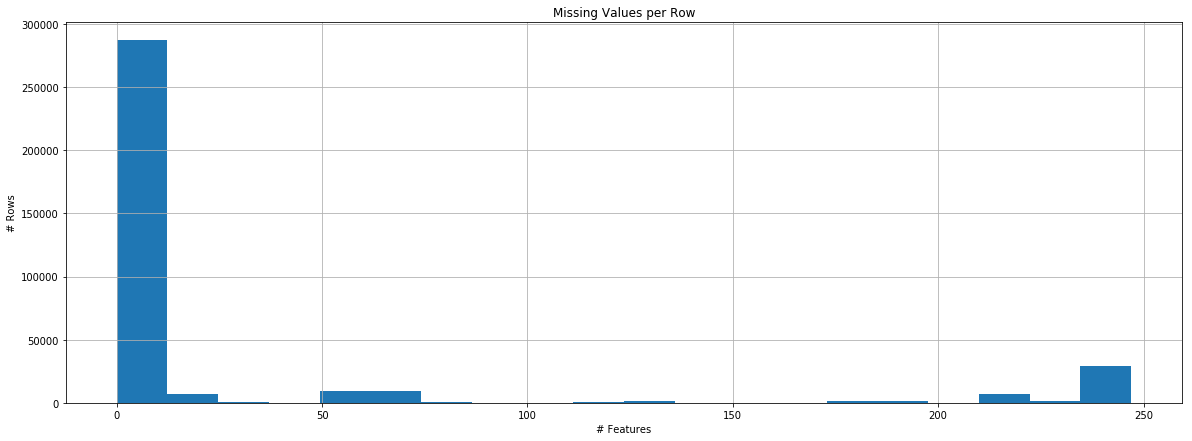

In [29]:
fig = plt.figure(figsize=(20,7))
azdias.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('# Features')
plt.ylabel('# Rows');

I'll use a threshold of 230 which means that rows that have more than 230 features missing will be dropped.

In [33]:
azdias = azdias.dropna(thresh=230)
azdias.shape

(314005, 328)

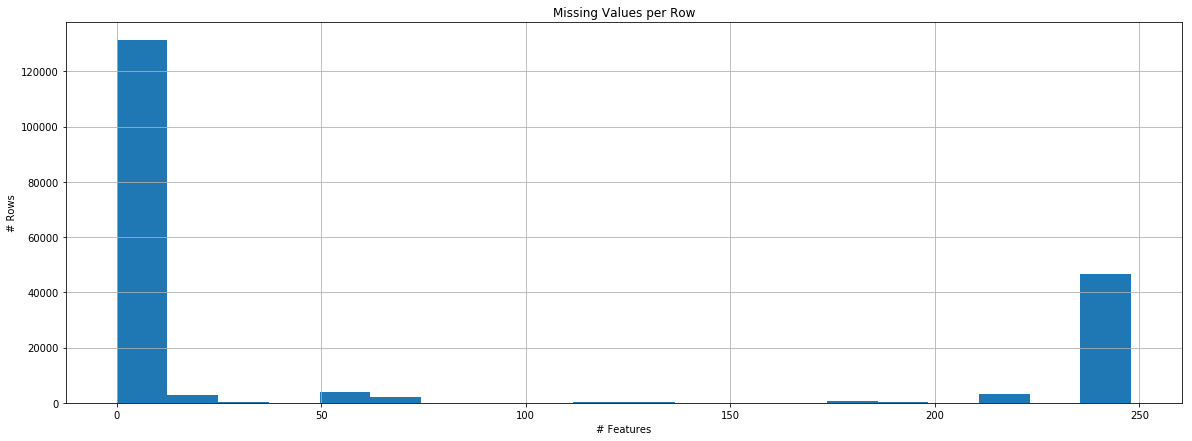

In [31]:
fig = plt.figure(figsize=(20,7))
customers.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('# Features')
plt.ylabel('# Rows');

In [34]:
customers = customers.dropna(thresh=230)
customers.shape

(140371, 331)

### Imputing missing values with most frquent value

Initially I tried Imputer from sklearn but received an error "could not convert string to float: 'W'". That's why I decided to write my custom impute function  

In [35]:
def impute(df):
    """
    Imputes the most frequent value per column.
    """
    df_copy = df.copy()
    columns = df_copy.columns[df_copy.isnull().any()]
    
    for col in columns:
        most_freq = df_copy.groupby([col])[col].count().sort_values(ascending=False).index[0]
        df_copy[col].fillna(most_freq, inplace=True)
    
    return df_copy

In [36]:
azdias = impute(azdias)
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,9.0,18.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
1,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
2,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3.0,2.0,4.0
3,910248,9.0,18.0,15.0,4.0,0.0,0.0,1.0,3.0,0.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4.0,2.0,2.0
5,612558,5.0,21.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,...,4.0,3.0,5.0,3.0,6.0,4.0,3.0,1.0,1.0,3.0


In [37]:
customers = impute(customers)
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
2,143872,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,6.0,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0
5,143888,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,6.0,9.0,1.0,2.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,3.0


### Encoding features and feature engineering

In [38]:
extra_col = list(set(customers.columns) - set(azdias.columns))
extra_col

['ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP']

We have three extra columns in customers dataset. We need to remove these three columns from the customers dataset.

In [39]:
customers.drop(extra_col, axis = 1, inplace = True)

From manual investigation, I found out that there are 6 numerical columns   

In [51]:
num_cols = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW', \
            'MIN_GEBAEUDEJAHR']

azdias_num = azdias[num_cols].copy(deep=True)
customers_num = customers[num_cols].copy(deep=True)

azdias_cat = azdias[list(set(azdias.columns) - set(num_cols))].copy(deep=True)
customers_cat = customers[list(set(customers.columns) - set(num_cols))].copy(deep=True)

In [52]:
print(azdias_num.shape)
print(azdias_cat.shape)
print(customers_num.shape)
print(customers_cat.shape)

(314005, 7)
(314005, 321)
(140371, 7)
(140371, 321)


Next, I will identify the columns with only two values so that I can convert them in binary columns.

In [53]:
categorical_binary=[]

for feature in azdias_cat.columns:
    if azdias_cat[feature].nunique() == 2:
        categorical_binary.append(feature)
        
categorical_binary

['KBA05_SEG6',
 'SOHO_KZ',
 'VERS_TYP',
 'DSL_FLAG',
 'UNGLEICHENN_FLAG',
 'GREEN_AVANTGARDE',
 'ANREDE_KZ',
 'KONSUMZELLE',
 'HH_DELTA_FLAG',
 'OST_WEST_KZ']

In [54]:
for col in categorical_binary:
    print(azdias[col].value_counts())

0.0    278897
1.0     35108
Name: KBA05_SEG6, dtype: int64
0.0    311348
1.0      2657
Name: SOHO_KZ, dtype: int64
2.0    170066
1.0    143939
Name: VERS_TYP, dtype: int64
1.0    305869
0.0      8136
Name: DSL_FLAG, dtype: int64
0.0    285767
1.0     28238
Name: UNGLEICHENN_FLAG, dtype: int64
0    244883
1     69122
Name: GREEN_AVANTGARDE, dtype: int64
2.0    163533
1.0    150472
Name: ANREDE_KZ, dtype: int64
0.0    239906
1.0     74099
Name: KONSUMZELLE, dtype: int64
0.0    286050
1.0     27955
Name: HH_DELTA_FLAG, dtype: int64
W    247494
O     66511
Name: OST_WEST_KZ, dtype: int64


In [55]:
#we need to convert OST_WEST_KZ categories from W and O to 0 and 1
o_w_k_dict = {'W':0, 'O':1}
azdias_cat['OST_WEST_KZ'] = azdias_cat['OST_WEST_KZ'].apply(lambda x:o_w_k_dict[x])
customers_cat['OST_WEST_KZ'] = customers_cat['OST_WEST_KZ'].apply(lambda x:o_w_k_dict[x])

I have identified a few columns, using which I will be creating a few other columns, in order to capture information in a better way.

In [56]:
#extract the time,and keep the year for column with date/time information
azdias_cat['EINGEFUEGT_AM']=pd.to_datetime(azdias_cat['EINGEFUEGT_AM']).dt.year
customers_cat['EINGEFUEGT_AM']=pd.to_datetime(customers_cat['EINGEFUEGT_AM']).dt.year

In [57]:
#extracting decade
decades_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90}

#mainstream or avant-garde movement
movement_dict = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}

azdias_cat['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_cat['PRAEGENDE_JUGENDJAHRE'].map(decades_dict)
customers_cat['PRAEGENDE_JUGENDJAHRE_DECADE'] = customers_cat['PRAEGENDE_JUGENDJAHRE'].map(decades_dict)

azdias_cat['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_cat['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
customers_cat['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = customers_cat['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

In [58]:
#Using CAMEO_INTL_2015 to create a wealth and family type feature
azdias_cat['WEALTH'] = azdias_cat['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
azdias_cat['LIFE_STAGE'] = azdias_cat['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

customers_cat['WEALTH'] = customers_cat['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
customers_cat['LIFE_STAGE'] = customers_cat['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

In [59]:
#dealing with LP_LEBENSPHASE_FEIN
life_stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

fine_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

life_dict = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
scale_dict = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

azdias_cat['LP_LEBENSPHASE_FEIN_life_stage'] = azdias_cat['LP_LEBENSPHASE_FEIN'].map(life_stage)
azdias_cat['LP_LEBENSPHASE_FEIN_fine_scale'] = azdias_cat['LP_LEBENSPHASE_FEIN'].map(fine_scale)
azdias_cat['LP_LEBENSPHASE_FEIN_life_stage'] = azdias_cat['LP_LEBENSPHASE_FEIN_life_stage'].map(life_dict)
azdias_cat['LP_LEBENSPHASE_FEIN_fine_scale'] = azdias_cat['LP_LEBENSPHASE_FEIN_fine_scale'].map(scale_dict)


customers_cat['LP_LEBENSPHASE_FEIN_life_stage'] = customers_cat['LP_LEBENSPHASE_FEIN'].map(life_stage)
customers_cat['LP_LEBENSPHASE_FEIN_fine_scale'] = customers_cat['LP_LEBENSPHASE_FEIN'].map(fine_scale)
customers_cat['LP_LEBENSPHASE_FEIN_life_stage'] = customers_cat['LP_LEBENSPHASE_FEIN_life_stage'].map(life_dict)
customers_cat['LP_LEBENSPHASE_FEIN_fine_scale'] = customers_cat['LP_LEBENSPHASE_FEIN_fine_scale'].map(scale_dict)

In [60]:
#dropping columns used to create new features
cols = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015' ,'LP_LEBENSPHASE_FEIN']
    
azdias_cat.drop(cols, axis = 1, inplace = True)
customers_cat.drop(cols, axis = 1, inplace = True)

In [62]:
print(azdias_cat.shape)
print(customers_cat.shape)
print(azdias_num.shape)
print(customers_num.shape)

(314005, 324)
(140371, 324)
(314005, 7)
(140371, 7)


In [47]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [48]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [49]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
